In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import cvxpy as cp
import diffrax

from soromox.systems.tendon_actuated_planar_pcs import TendonActuatedPlanarPCS

from MPC import LinearizedMPC

In [2]:
num_segments = 1  # number of segments in the robot
params = {
    "th0": jnp.array(jnp.pi / 2),  # initial orientation angle [rad]
    "L": 1e-1 * jnp.ones((num_segments,)),
    "r": 2e-2 * jnp.ones((num_segments,)),
    "rho": 1070 * jnp.ones((num_segments,)),  # Volumetric density of Dragon Skin 20 [kg/m^3]
    "g": jnp.array([0.0, 9.81]),  # gravitational acceleration [m/s^2] UP!
    "E": 5e3 * jnp.ones((num_segments,)),  # Elastic modulus [Pa]
    "G": 1e3 * jnp.ones((num_segments,)),  # Shear modulus [Pa]
    "d": 2e-2 * jnp.array([[1.0, -1.0]]).repeat(num_segments, axis=0),  # distance of tendons from the central axis [m]
}
params["D"] = 1e-3 * jnp.diag((jnp.repeat(jnp.array([[1e0, 1e3, 1e3]]), num_segments, axis=0) * params["L"][:, None]).flatten())
strain_selector = jnp.ones((3 * num_segments,), dtype=bool) # activate all strains (i.e. bending, shear, and axial)
segment_actuation_selector = jnp.ones((num_segments,), dtype=bool)  # actuation selector for the segments

robot = TendonActuatedPlanarPCS(num_segments=num_segments, params=params, strain_selector=strain_selector, segment_actuation_selector=segment_actuation_selector)

nx = 2 * 3 * num_segments
nu = 2 * num_segments

In [5]:
N = 50
dt = 0.0001
Q = np.diag([50.0] * int(nx/2) + [1.0] * int(nx/2))
R = np.diag([0.001] * nu)

@jax.jit
def discrete_dynamics(x, u):
    x_next = diffrax.diffeqsolve(terms=diffrax.ODETerm(robot.forward_dynamics), solver=diffrax.Tsit5(), t0=0.0, t1=dt, dt0=1e-3, y0=x, args=(u,), saveat=diffrax.SaveAt(ts=[dt])).ys
    return x_next

controller = LinearizedMPC(discrete_dynamics, N, dt, nx, nu, Q, R)

In [6]:
# ---------------------------------------------------------
# 4. SIMULATION USING JAX REAL DYNAMICS
# ---------------------------------------------------------
@jax.jit
def simulate_step(x, u):
    sol = diffrax.diffeqsolve(terms=diffrax.ODETerm(robot.forward_dynamics), solver=diffrax.Tsit5(), t0=0.0, t1=dt, dt0=1e-4, y0=x, args=(u,), saveat=diffrax.SaveAt(ts=[dt]))
    return sol.ys

T_sim = 1e-2
steps = int(T_sim / dt)

q = np.zeros((int(nx/2)))
qd = np.zeros_like(q)
x = np.concatenate([q, qd])

q_target = np.asarray(robot.inverse_kinematics(jnp.array([[-jnp.pi/2, 0.0, 1e-1]])))
qd_target = np.zeros_like(q_target)
x_target = np.concatenate([q_target, qd_target])

# controller.x_hat.value = np.tile(x, (N+1, 1))

trajectory_x = [x]
trajectory_u = []
trajectory_pos = [robot.forward_kinematics_tips(q)]
trajectory_cost = x.T @ controller.Q @ x

for t in range(steps):
    x_mpc_sol, u_mpc_sol, cost_mpc_sol = controller.solve_ocp(x, x_ref=x_target, num_iterations=20)

    # real JAX dynamics simulation
    u_apply = u_mpc_sol[0, :]     # first control input
    x = np.asarray(simulate_step(x, u_apply)).squeeze()
    q, qd = np.split(x, 2)
    trajectory_x.append(x)
    trajectory_u.append(u_apply)
    trajectory_pos.append(robot.forward_kinematics_tips(q))
    trajectory_cost += x.T @ controller.Q @ x + u_apply.T @ controller.R @ u_apply

trajectory_x = np.array(trajectory_x).reshape(steps+1, nx, 1)
trajectory_u = np.array(trajectory_u).reshape(steps, nu, 1)
trajectory_pos = np.array(trajectory_pos).reshape(steps+1, num_segments, 3)

print("Finished CVXPY MPC simulation.")
print("Trajectory Cost: ", trajectory_cost * dt)

0.0 0.0
46.804630853623735 20.142599151869373
26.862207979719088 4.686851920597816
Iteration 1: ||du|| = 4.686851920597816, status: 2524604.26798672
26.862207979719088 4.6868519205978165
144466.1517750847 20.149318479072072


TypeError: unsupported operand type(s) for *: 'NoneType' and 'NoneType'

In [ ]:
A = controller.Jac_x(np.zeros(nx), np.zeros(nu))
print(np.linalg.eigvals(A))

[-2.90452822e+03+0.j         -8.66130642e+01+0.j
 -1.45502886e+00+0.14367323j -1.45502886e+00-0.14367323j
 -2.16643529e+02+0.j         -6.47085574e+00+0.j        ]


In [ ]:
q_eq = robot.inverse_kinematics(jnp.array([[-jnp.pi/2, 0.0, -1e-1]]))
qd_eq = jnp.zeros_like(q_eq)
print(robot.forward_dynamics(None, jnp.concatenate([q_eq, qd_eq])))

[      0.               0.               0.         -170616.93801479
   11819.64558733   -3386.88283815]


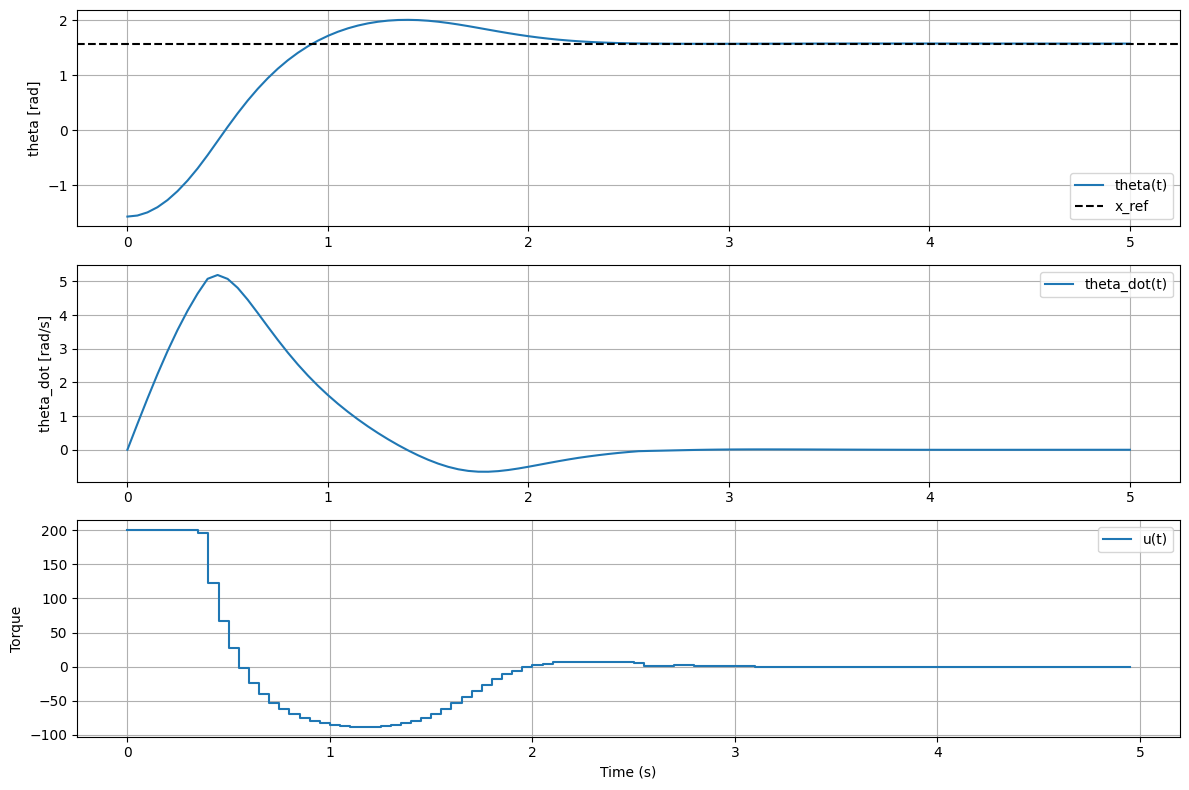

In [ ]:
import matplotlib.pyplot as plt

trajectory_x = np.array(trajectory_x)
trajectory_u = np.array(trajectory_u)
time = np.arange(trajectory_x.shape[0]) * dt

plt.figure(figsize=(12,8))

# -----------------------------
# Plot Theta
# -----------------------------
plt.subplot(3,1,1)
plt.plot(time, trajectory_x[:, 0].squeeze(), label="theta(t)")
plt.axhline(x_eq[0], color="k", linestyle="--", label="x_ref")
plt.ylabel("theta [rad]")
plt.legend()
plt.grid(True)

# -----------------------------
# Plot Theta_dot
# -----------------------------
plt.subplot(3,1,2)
plt.plot(time, trajectory_x[:, 1].squeeze(), label="theta_dot(t)")
plt.ylabel("theta_dot [rad/s]")
plt.legend()
plt.grid(True)

# -----------------------------
# Plot Control Input
# -----------------------------
plt.subplot(3,1,3)
plt.step(time[:-1], trajectory_u[:, 0].squeeze(), where="post", label="u(t)")
plt.ylabel("Torque")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
